# Analisis de la serire de Tiempo BTCUSDT y predicción usando ARIMA

In [2]:
import pandas as pd
import numpy as np
import gc
from binance.client import Client
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
def get_data(api_key, api_secret, initial_date, final_date, pair, time_frame):
    
    '''Returns a DataFrame that contains all the information about the 
       historical price of a pair of cryptocurrencies '''
    
    client = Client(api_key, api_secret)
    klines = client.get_historical_klines(pair , time_frame, initial_date, final_date)
    information = np.array(klines, dtype=float)
    df = pd.DataFrame(information, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
             'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
             'Taker buy quote asset volume', 'Can be ignored'])
    df['Open time'] = pd.to_datetime(df['Open time'], utc=True, unit='ms')
    df['Close time'] = pd.to_datetime(df['Close time'], utc=True, unit='ms')
    #df.isnull().values.any()
    return df

def plot_figure(label1, label2):
    '''Graph label1 as a function of label2'''
    plt.figure(figsize=(20,8))
    plt.grid(True)
    plt.plot(label1, label2)
    plt.xlabel(label1.name)
    plt.ylabel(label2.name)
    #plt.title('Close Prices 2017-12-01 and 2018-01-01')
    plt.show()

In [4]:
#Parametros necesarios para descargar la serire de tiempo BTCUSDT
api_key = 'IbpsF5kqc5Jr34cPrYtugWoIuuVf05GokqOC0TcS35mwtpb5UpsaST1fePtRJL7F'
api_secret = 'kvWWitpU5fFMtucgr0YYIV0Z33Y1EwfEBRc57ey0G5UzHMmKgdWer8G1pwkWmjuc'
initial_date ='1 Dec, 2015'
final_date ='1 Jan, 2019'
pair = "BTCUSDT"
time_frame = Client.KLINE_INTERVAL_1HOUR

In [5]:
#Obtener la información para la serie de tiempo de una hora
data_1HOUR = get_data(api_key, api_secret, initial_date, final_date, pair, time_frame)

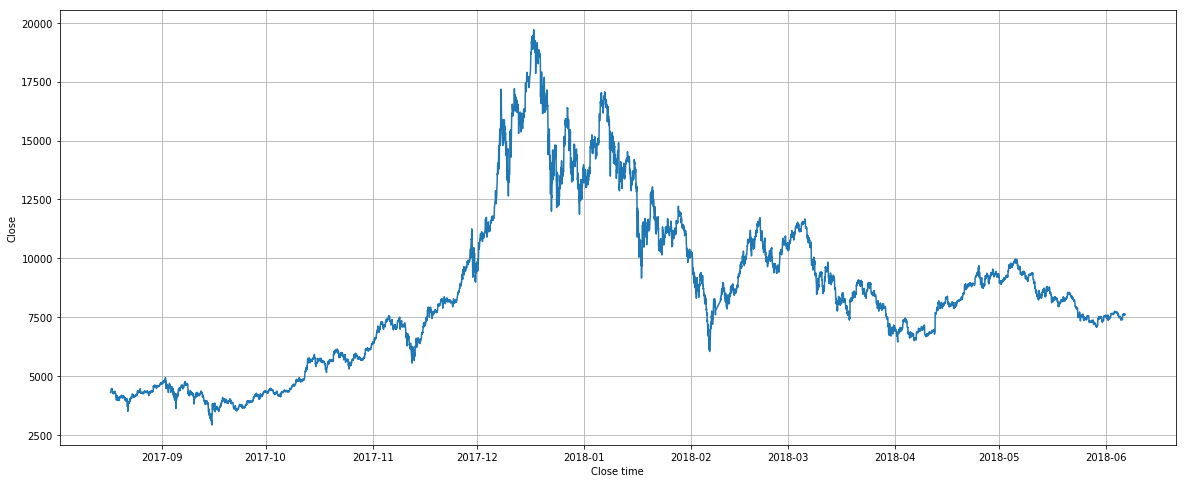

In [6]:
#Graficar la información de la serie de tiempo
plot_figure(data_1HOUR['Close time'], data_1HOUR['Close'])

In [7]:
#Guardar los datos del cambio en el precio de cierre
Close_price = data_1HOUR['Close'].values
Close_price_DF = data_1HOUR['Close'].copy()

#Generar los arreglos con la información de las primeras diferencias y las segundas diferencias

#Primeras diferencias
Change_Price=Close_price.copy()
for ii in range (len(Close_price)):
    Change_Price[ii] = (Close_price[ii]-Close_price[ii-1])#-(Close_price[ii-1]-Close_price[ii-2])
Change_Price= Change_Price[1:]
Change_Price_DF =pd.DataFrame(Change_Price)

#Segundas diferencias
Change_Price_2 = Close_price.copy()
for ii in range (len(Close_price)):
    Change_Price_2[ii] = (Close_price[ii]-Close_price[ii-1])-(Close_price[ii-1]-Close_price[ii-2])
Change_Price_2=Change_Price_2[1:]
Change_Price_2_DF = pd.DataFrame(Change_Price_2)

### Primeras Diferencias 

Histograma para las primeras diferencias en el precio, se espera que el comportamiento sea aproximadamente normal

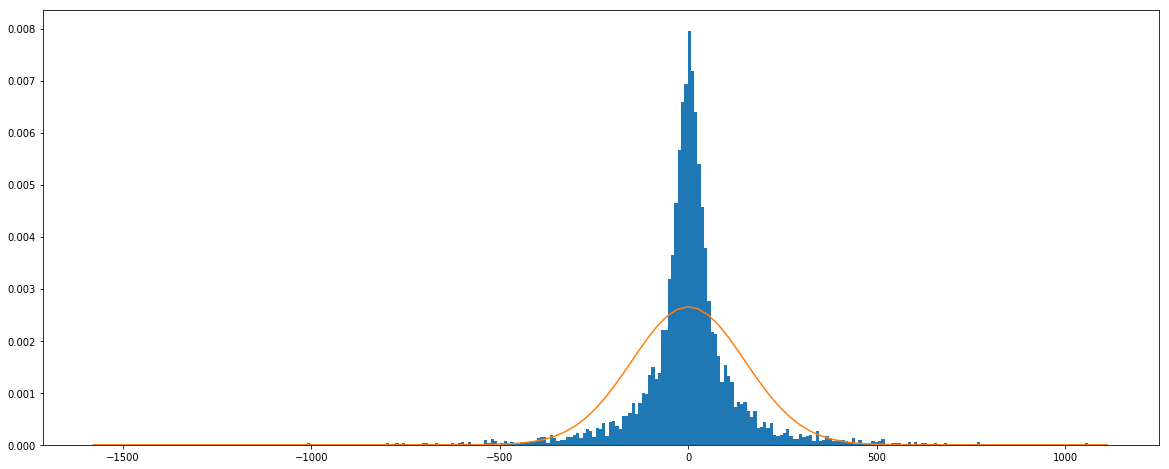

In [8]:
plt.gcf().clear()
plt.figure(figsize=(20,8))
Hist_1_x = plt.hist(Change_Price, bins='auto',normed=True)
mean = np.mean(Change_Price)
variance = np.var(Change_Price)
sigma = np.sqrt(variance)

Min=np.amin(Change_Price)
Max=np.amax(Change_Price)
x = np.linspace(Min,Max,100)

import matplotlib.mlab as mlab
#plt.gcf().clear()

plt.plot(x, mlab.normpdf(x, mean, sigma))
plt.show()

Grafica QQ para determinar si las primeras diferencias tiene un comportamiento que se puede identificar con una distribución normal

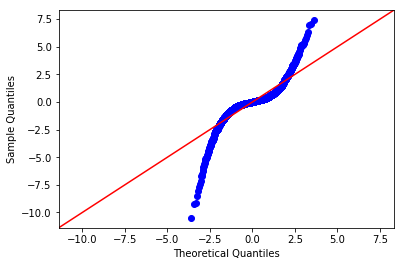

In [16]:
from matplotlib.pyplot import figure
Change_Price_Normalize = Change_Price.copy()
for ii in range(len(Change_Price)):
    Change_Price_Normalize[ii] = (Change_Price[ii]-mean)/sigma

#QQPlot to test normality for the distribution
import statsmodels.api as sm
import pylab
test = np.random.normal(0,1, 1000)

figure(figsize=(8,6))
sm.qqplot(Change_Price_Normalize, line='45')
pylab.show()
#np.amax(Change_Price_Normalize)

### Cambio porcentual del precio 

Se estudia el cambio porcentual en los precios

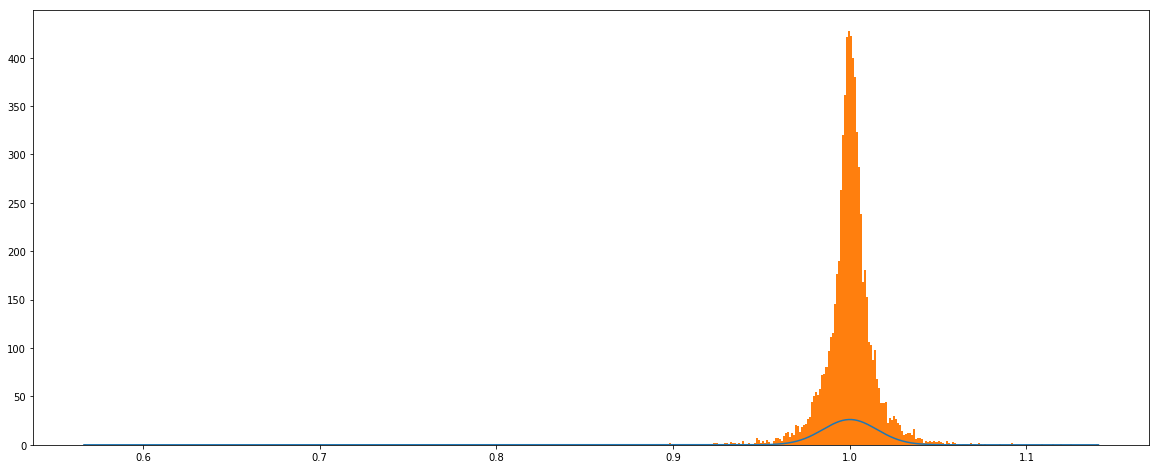

In [17]:
from math import log
plt.gcf().clear()
Change_Price_Porcentual = Close_price.copy()
for ii in range (len(Change_Price_Porcentual)):
    Change_Price_Porcentual[ii-1] = (Close_price[ii])/Close_price[ii-1]
Change_Price_Porcentual = Change_Price_Porcentual[1:]

Max_Porcentual = np.amax(Change_Price_Porcentual)
Min_Porcentual = np.amin(Change_Price_Porcentual)
mean_Por = np.mean(Change_Price_Porcentual)
variance_Por = np.var(Change_Price_Porcentual)
sigma_Por = np.sqrt(variance_Por)
x_1 = np.linspace(Min_Porcentual,Max_Porcentual,1000)

import matplotlib.mlab as mlab
#plt.gcf().clear()
plt.figure(figsize=(20,8))
plt.plot(x_1, mlab.normpdf(x_1, mean_Por, sigma_Por))
Hist_Porcentual = plt.hist(Change_Price_Porcentual, bins='auto')
plt.show()

Se grafica la grafica QQ para el cambio porcentual de los precios.

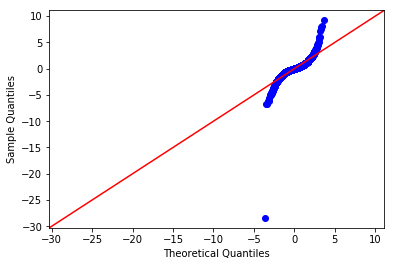

In [20]:
mean_Por = np.mean(Change_Price_Porcentual)
variance_Por = np.var(Change_Price_Porcentual)
sigma_Por = np.sqrt(variance_Por)

Change_Price_Porcentual_Normalize = Change_Price_Porcentual.copy()
for ii in range(len(Change_Price_Porcentual)):
    Change_Price_Porcentual_Normalize[ii] = (Change_Price_Porcentual[ii]-mean_Por)/sigma_Por

#QQPlot to test normality for the distribution
import statsmodels.api as sm
import pylab
test = np.random.normal(0,1, 1000)
figure(figsize=(8,6))
#plt.figure(figsize=(20,8))
sm.qqplot(Change_Price_Porcentual_Normalize, line='45')
pylab.show()
#np.amax(Change_Price_Normalize)

El cambio porcentual tiene una distribución similar al cambio del precio, sin embargo, tiene colas más pesadas que la distribución de los cambios en el precio. 

Se estudia la serie de tiempo para las segundas diferencias.

### Segundas Diferencias 

Histograma para las segundas diferencias

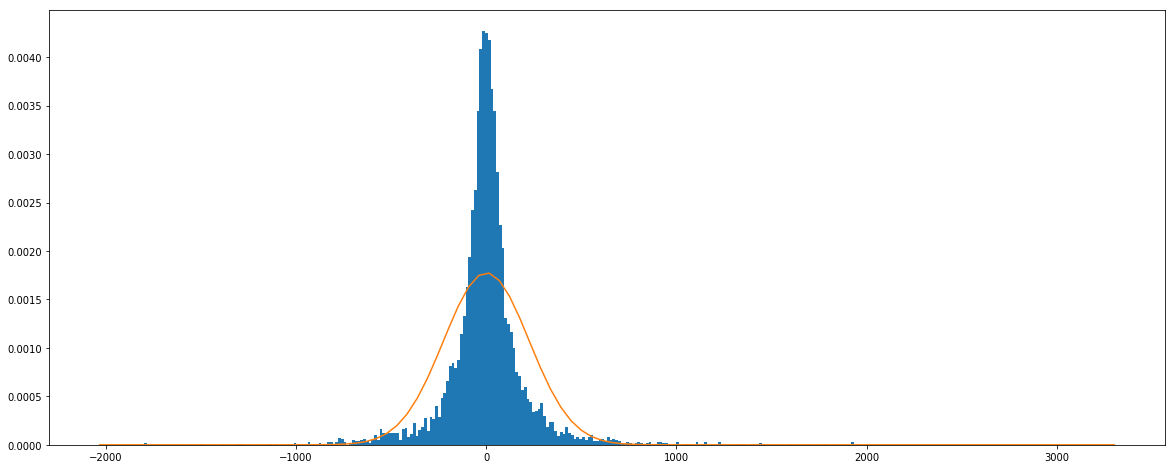

In [21]:
plt.gcf().clear()
plt.figure(figsize=(20,8))
plt.figure(figsize=(20,8))
Hist_1_x = plt.hist(Change_Price_2, bins='auto',normed=True)
mean_2 = np.mean(Change_Price_2)
variance_2 = np.var(Change_Price_2)
sigma_2 = np.sqrt(variance_2)

Min_2=np.amin(Change_Price_2)
Max_2=np.amax(Change_Price_2)
x_2 = np.linspace(Min_2,Max_2,100)

import matplotlib.mlab as mlab
#plt.gcf().clear()
plt.plot(x_2, mlab.normpdf(x_2, mean_2, sigma_2))
plt.show()

Grafica QQ para determinar si las segundas diferencias tiene un comportamiento que se puede identificar con una distribución normal

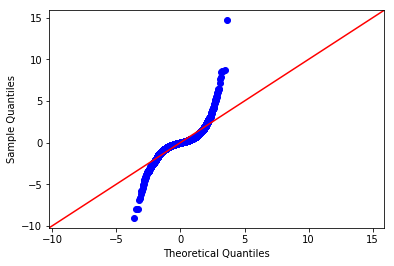

In [22]:
Change_Price_2_Normalize = Change_Price_2.copy()
for ii in range(len(Change_Price_2)):
    Change_Price_2_Normalize[ii] = (Change_Price_2[ii]-mean_2)/sigma_2

#QQPlot to test normality for the distribution
import statsmodels.api as sm
import pylab
figure(figsize=(20,8))
sm.qqplot(Change_Price_2_Normalize, line='45')
pylab.show()
#np.amax(Change_Price_Normalize)

Se observa un comportamiento más cercano al normal para las primeras diferencias, ya que las segundas diferencias se alejan más de la recta identidad en la gráfica QQ, esto implica que d=1 es un buen estimado para ajustar el modelos ARIMA(p,d,q)

# ARIMA

Identificar los parametros del modelo: p,d,q. Se ajusta el orden de diferenciación de la serie siguiendo lo propuesto en https://people.duke.edu/~rnau/411arim2.htm. Se ajusta una modelo ARIMA(0,1,0) y ARIMA(0,2,0) con la serie de datos y se observa cómo se distribuyen los errores.

## Autocorrelación y Autocorrelación Parcial 

Se calcula la autocorrelación para la serie del valor del precio de cierre

/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  import sys


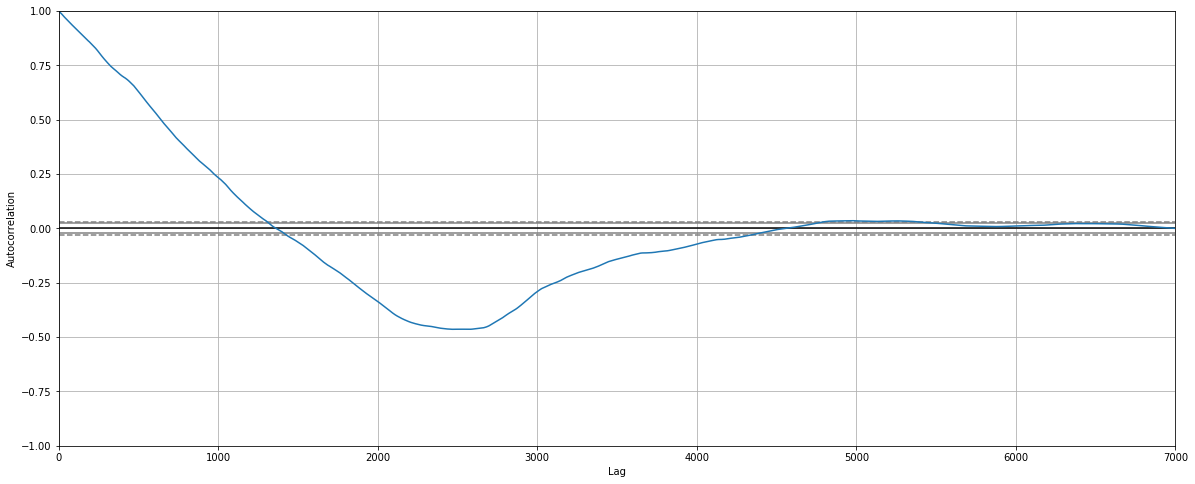

In [23]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas.tools.plotting import autocorrelation_plot

plt.figure(figsize=(20,8))
autocorrelation_plot(Close_price_DF)
pyplot.show()

Se observa un decaimiento lineal en la autocorrelación, luego, esta serie no sigue un comportamiento normal

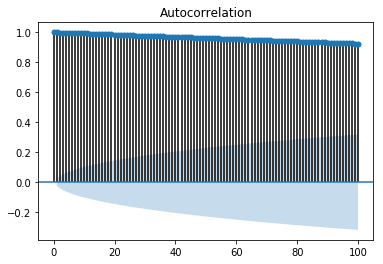

In [26]:
from statsmodels.graphics.tsaplots import plot_acf
figure(figsize=(20,8))
plot_acf(Close_price_DF,lags=100)
pyplot.show()

Función de autocorrelación parcial para la serire de tiempo del precio de cierre. Se observa que la serie tiene una fuerte autocorrelación parcial para t=2, luego, no se se distribuye normalmente.

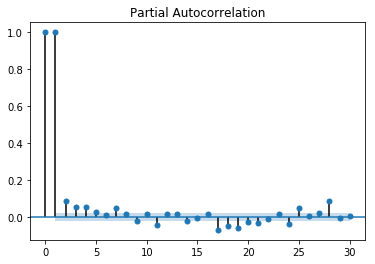

In [27]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(20,8))
plot_pacf(Close_price_DF, lags=30)
pyplot.show()

### Ajuste ARIMA(0,1,0) y ARIMA(0,2,0) 

ARIMA(0,0,0) que implica no realizar ningún ajuste sobre la serie de tiempo.

In [28]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Close_price_DF, order=(0,0,0))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 6997
Model:                     ARMA(0, 0)   Log Likelihood              -66927.899
Method:                           css   S.D. of innovations           3450.551
Date:                Wed, 06 Jun 2018   AIC                         133859.798
Time:                        03:46:14   BIC                         133873.504
Sample:                             0   HQIC                        133864.521
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8592.6634     41.251    208.303      0.000    8511.813    8673.514


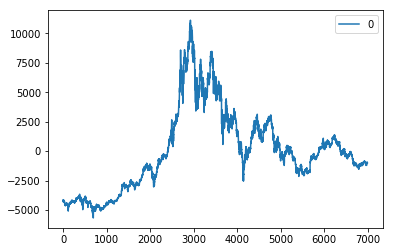

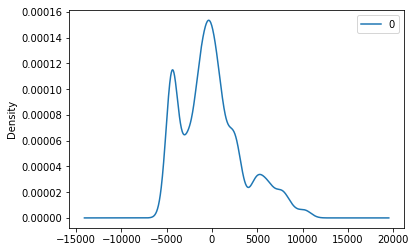

                  0
count  6.997000e+03
mean  -5.324125e-13
std    3.450798e+03
min   -5.673663e+03
25%   -2.568593e+03
50%   -3.706634e+02
75%    1.807337e+03
max    1.111684e+04


In [29]:
from pandas import DataFrame
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

ARIMA(0,1,0). Los errores del ajuste de este modelo tienen un media de 3.38e-15 y desviación estándar 1.50e02.

In [30]:
model_1 = ARIMA(Close_price_DF, order=(0,1,0))
model_1_fit = model_1.fit(disp=-1)
print(model_1_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 6996
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -44998.812
Method:                           css   S.D. of innovations            150.376
Date:                Wed, 06 Jun 2018   AIC                          90001.623
Time:                        03:46:20   BIC                          90015.329
Sample:                             1   HQIC                         90006.346
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4712      1.798      0.262      0.793      -3.053       3.995


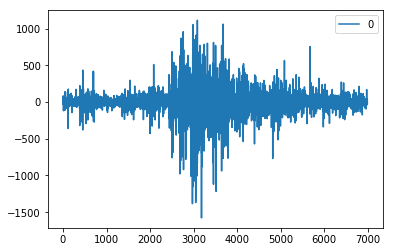

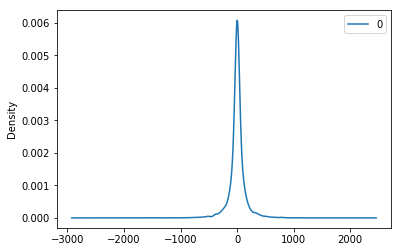

                 0
count  6996.000000
mean      0.000000
std     150.386713
min   -1578.341176
25%     -39.971176
50%       1.533824
75%      43.406324
max    1112.598824


In [31]:
# plot residual errors
residuals = DataFrame(model_1_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

Autocorrelación y Autocorrelación parcial para la serie de las primeras diferencias

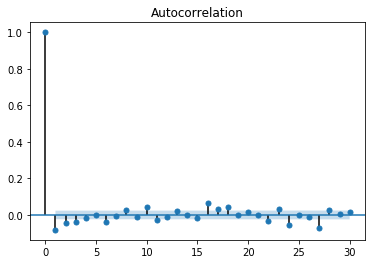

In [33]:
figure(figsize=(8,6))
plot_acf(Change_Price_DF,lags=30)
pyplot.show()

La autocorrelación decae exponencialmente, luego, se puede tomar p<=8 y de forma similar q<=8.

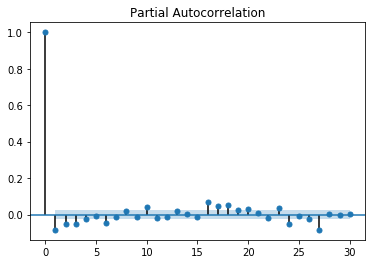

In [34]:
plt.figure(figsize=(20,8))
plot_pacf(Change_Price_DF, lags=30)
pyplot.show()

La autocorrelación parcial para t=2 es aproximadamente -0.1, lo cual implica que no se está sobre diferenciando la serie.

ARIMA(0,1,0). Los errores del ajuste de este modelo tienen un media de -4.85e-15 y desviación estándar 2.21e02.

In [35]:
model_1 = ARIMA(Close_price_DF, order=(0,2,0))
model_1_fit = model_1.fit(disp=-1)
print(model_1_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 6995
Model:                 ARIMA(0, 2, 0)   Log Likelihood              -47692.595
Method:                           css   S.D. of innovations            221.220
Date:                Wed, 06 Jun 2018   AIC                          95389.190
Time:                        03:46:41   BIC                          95402.896
Sample:                             2   HQIC                         95393.913
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      2.645     -0.001      0.999      -5.187       5.181


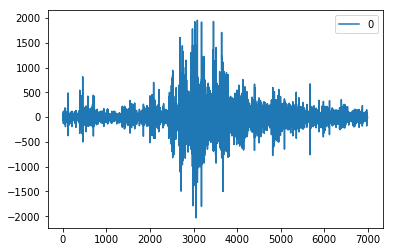

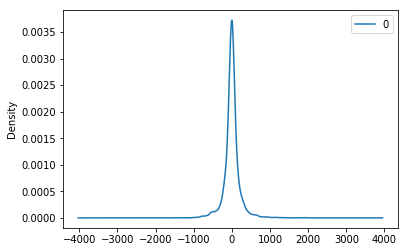

                  0
count  6.995000e+03
mean   4.735597e-15
std    2.212362e+02
min   -2.033247e+03
25%   -7.153708e+01
50%   -8.570751e-01
75%    6.801292e+01
max    1.955093e+03


In [36]:
# plot residual errors
residuals = DataFrame(model_1_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

Autocorrelación y autocorrelación parcial para la serie de las segundas diferencias. 

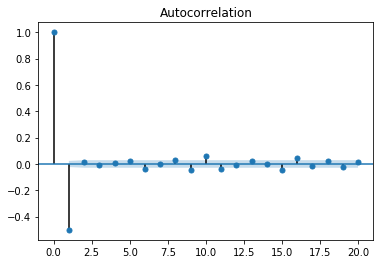

In [37]:
plt.figure(figsize=(20,8))
plot_acf(Change_Price_2_DF,lags=20)
pyplot.show()

La autocorrelación para las segundas diferencias tiene un valor muy negativo pra t=2, lo cual implica que se está sobre diferenciando si se quieren usar los mínimos valores apropiados de (p,d,q) para ajustar el modelo ARIMA(p,d,q)

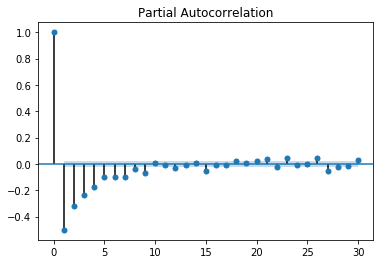

In [38]:
plt.figure(figsize=(20,8))
plot_pacf(Change_Price_2_DF, lags=30)
pyplot.show()

La autocorrelación parcial toma valores menores a -0.2 para t=2,3, lo cual implica que se está sobre diferenciando la serie.

## AIC/BCI para determinar cuales son los mejores valores para p,q

In [307]:
from statsmodels.tsa.arima_model import ARMAResults 
#print(ARMAResults.aic(model_1_fit))

Results_AIC_BIC = np.ndarray(shape=(8,8,2))
dif=1
for ii in range(8):
    for jj in range(8):
        model = ARIMA(Close_price_DF, order=(ii,dif,jj))
        try:
            dif=1
            model_fit = model.fit(disp=0)
            print(ii,jj,dif)
            Results_AIC_BIC[ii,jj,0]=ARMAResults.aic(model_fit)
            Results_AIC_BIC[ii,jj,1]=ARMAResults.bic(model_fit)
        except Exception:
            try:
                dif=2
                model = ARIMA(Close_price_DF, order=(ii,dif,jj))
                model_fit = model.fit(disp=0)
                print(ii,jj,dif)
                Results_AIC_BIC[ii,jj,0]=ARMAResults.aic(model_fit)
                Results_AIC_BIC[ii,jj,1]=ARMAResults.bic(model_fit)
            except Exception:    
                Results_AIC_BIC[ii,jj,0]=pow(10.0,8)
                Results_AIC_BIC[ii,jj,1]=pow(10.0,8)


0 0 1
0 1 1
0 2 1
0 3 1
0 4 1
0 5 1
0 6 1
0 7 1
1 0 1
1 1 1
1 2 1
1 3 1
1 4 2
1 5 1
1 6 2
1 7 1
2 0 1
2 1 1
2 2 1
2 3 1
2 5 1
2 6 2


/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2 7 1
3 0 1
3 1 1
3 2 1
3 4 1
3 5 2
3 6 1
3 7 2
4 0 1
4 1 1
4 2 1
4 3 2
4 4 1
4 5 2
4 6 1


/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 7 2
5 0 1
5 1 1
5 2 1
5 3 1
5 4 1


/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 5 2


/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


5 6 1
5 7 2
6 0 1
6 1 1
6 2 1
6 3 1
6 4 1


/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


6 5 2


/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/ho

6 6 1


/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


6 7 2
7 0 1
7 1 1
7 2 1
7 3 1
7 4 1


/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7 5 1


/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7 6 2
7 7 1


/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [312]:
AIC = Results_AIC_BIC[:,:,0]
BIC = Results_AIC_BIC[:,:,1]
AIC[6,6] = pow(10.0,8)
BIC[6,6] = pow(10.0,8)
Min_AIC = np.amin(AIC)
Min_BIC = np.amin(BIC)
print(Min_AIC,', ',Min_BIC)
BIC

88759.92385495637 ,  88835.17182904076


array([[8.89900690e+04, 8.89467826e+04, 8.89344830e+04, 8.89282769e+04,
        8.89346870e+04, 8.89434667e+04, 8.89424532e+04, 8.89511323e+04],
       [8.89523770e+04, 8.89168215e+04, 8.89255776e+04, 8.89333536e+04,
        8.89500333e+04, 8.89484510e+04, 8.89526038e+04, 8.89612627e+04],
       [8.89418312e+04, 8.89255730e+04, 8.88540265e+04, 8.89421377e+04,
        1.00000000e+08, 8.89434211e+04, 8.89119317e+04, 8.89206584e+04],
       [8.89338051e+04, 8.89333651e+04, 8.89421713e+04, 1.00000000e+08,
        8.89059610e+04, 8.89393083e+04, 8.89492159e+04, 8.89579632e+04],
       [9.04055900e+04, 8.89421760e+04, 8.89509841e+04, 8.89451016e+04,
        8.89135148e+04, 8.89483222e+04, 8.89264560e+04, 8.89396627e+04],
       [9.02442971e+04, 8.89507633e+04, 8.89594222e+04, 8.89371809e+04,
        8.88351718e+04, 8.88779119e+04, 8.89364026e+04, 8.89557014e+04],
       [9.00694051e+04, 8.89494205e+04, 8.89568987e+04, 8.89434268e+04,
        8.89338065e+04, 8.89652940e+04, 1.00000000e+08, 8.

Mejor fit se consiguio con p=5,q=4,d=1. 

Se procede a calcular la predición de la serie de tiempo para el modelo ARIMA(5,1,4), para ello se entrena el modelo en cada de paso de tiempo con la serie de tiempo actualizada y se predice el siguiente paso de tiempo.

In [150]:
X = Close_price_DF.values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    History_DF = pd.DataFrame(history)
    model = ARIMA(history, order=(5,1,4))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
            

predicted=9303.252962, expected=9365.280000
predicted=9362.254033, expected=9357.000000
predicted=9347.056029, expected=9358.980000
predicted=9354.436978, expected=9376.700000
predicted=9366.372027, expected=9430.490000
predicted=9413.591446, expected=9453.900000
predicted=9443.167174, expected=9399.790000
predicted=9388.588109, expected=9309.860000
predicted=9312.418897, expected=9365.000000
predicted=9359.761733, expected=9395.630000
predicted=9388.538287, expected=9420.000000
predicted=9420.659049, expected=9439.990000
predicted=9433.897238, expected=9444.000000
predicted=9445.724427, expected=9430.520000
predicted=9435.359085, expected=9334.000000
predicted=9348.980023, expected=9340.000000
predicted=9355.917548, expected=9370.000000
predicted=9377.444103, expected=9398.950000
predicted=9409.219495, expected=9310.000000
predicted=9330.041603, expected=9295.000000
predicted=9307.427117, expected=9198.000000
predicted=9224.832515, expected=9140.000000
predicted=9161.584708, expected=

predicted=8716.228507, expected=8783.190000
predicted=8787.204924, expected=8760.000000
predicted=8760.131201, expected=8762.180000
predicted=8753.241524, expected=8740.750000
predicted=8732.322441, expected=8500.000000
predicted=8505.022829, expected=8517.010000
predicted=8509.721831, expected=8537.000000
predicted=8525.848130, expected=8547.900000
predicted=8533.068725, expected=8508.400000
predicted=8494.706104, expected=8554.990000
predicted=8536.166904, expected=8512.150000
predicted=8499.163652, expected=8472.720000
predicted=8463.876471, expected=8451.950000
predicted=8443.453553, expected=8462.000000
predicted=8456.171732, expected=8437.000000
predicted=8435.181319, expected=8315.010000
predicted=8326.663316, expected=8113.000000
predicted=8143.242286, expected=8140.000000
predicted=8159.976618, expected=8202.010000
predicted=8220.370048, expected=8200.000000
predicted=8220.067446, expected=8218.710000
predicted=8232.821944, expected=8216.220000
predicted=8232.391870, expected=

predicted=7908.691102, expected=7912.040000
predicted=7910.480465, expected=7945.850000
predicted=7945.342812, expected=7838.000000
predicted=7842.467989, expected=7840.990000
predicted=7841.586226, expected=7835.000000
predicted=7836.486085, expected=7842.990000
predicted=7838.927422, expected=7834.000000
predicted=7833.466916, expected=7909.320000
predicted=7898.110500, expected=7890.670000
predicted=7883.343267, expected=7870.000000
predicted=7866.311816, expected=7691.000000
predicted=7699.888376, expected=7601.000000
predicted=7616.709490, expected=7495.980000
predicted=7516.506392, expected=7478.950000
predicted=7497.830376, expected=7589.990000
predicted=7597.860835, expected=7585.020000
predicted=7593.459313, expected=7650.000000
predicted=7651.572837, expected=7536.000000
predicted=7546.537429, expected=7501.950000
predicted=7509.990932, expected=7577.290000
predicted=7573.546776, expected=7585.660000
predicted=7582.223478, expected=7557.980000
predicted=7554.594723, expected=

/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered

predicted=7415.062349, expected=7416.010000
predicted=7411.464279, expected=7442.240000
predicted=7436.849529, expected=7440.960000
predicted=7434.425994, expected=7389.880000
predicted=7389.713912, expected=7457.000000
predicted=7447.665612, expected=7443.270000
predicted=7437.724979, expected=7437.110000
predicted=7435.182095, expected=7416.410000
predicted=7413.290826, expected=7435.460000
predicted=7434.803887, expected=7385.600000
predicted=7390.018618, expected=7435.600000
predicted=7433.608390, expected=7420.110000
predicted=7425.518871, expected=7550.000000
predicted=7539.911958, expected=7543.250000
predicted=7543.545174, expected=7540.010000
predicted=7537.317625, expected=7532.000000
predicted=7529.000197, expected=7528.680000
predicted=7532.518799, expected=7520.420000
predicted=7521.258141, expected=7532.220000
predicted=7534.022005, expected=7518.800000
predicted=7525.347601, expected=7542.770000
predicted=7542.069428, expected=7524.570000
predicted=7532.842031, expected=

predicted=7641.290216, expected=7653.790000
predicted=7654.718572, expected=7623.100000
predicted=7635.205978, expected=7631.240000
predicted=7640.438757, expected=7642.370000
predicted=7651.112658, expected=7660.290000
predicted=7672.994664, expected=7665.000000
predicted=7671.791896, expected=7612.070000
predicted=7628.646864, expected=7639.890000
predicted=7649.080657, expected=7631.000000
predicted=7638.393650, expected=7640.030000
predicted=7650.024925, expected=7660.080000
predicted=7659.438489, expected=7650.590000
predicted=7654.409552, expected=7641.410000
predicted=7642.332941, expected=7643.100000
predicted=7637.944555, expected=7645.280000
predicted=7644.612675, expected=7655.000000
predicted=7645.307410, expected=7729.640000
predicted=7715.350066, expected=7720.000000
predicted=7707.698308, expected=7755.250000
predicted=7736.314973, expected=7753.630000
predicted=7743.093314, expected=7703.800000
predicted=7695.096779, expected=7714.850000
predicted=7705.484331, expected=

In [152]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 2869.647


El error parece no ser muy grande, sin embargo, una mirada más atenta a la serie de tiempo y la predicción hecha por ARIMA(5,1,4) revela que le predicción aporta poca información sobre el comportamiento futuro de la serie, ya que en su mayoría reproduce la serie de tiempo un paso en el futuro.

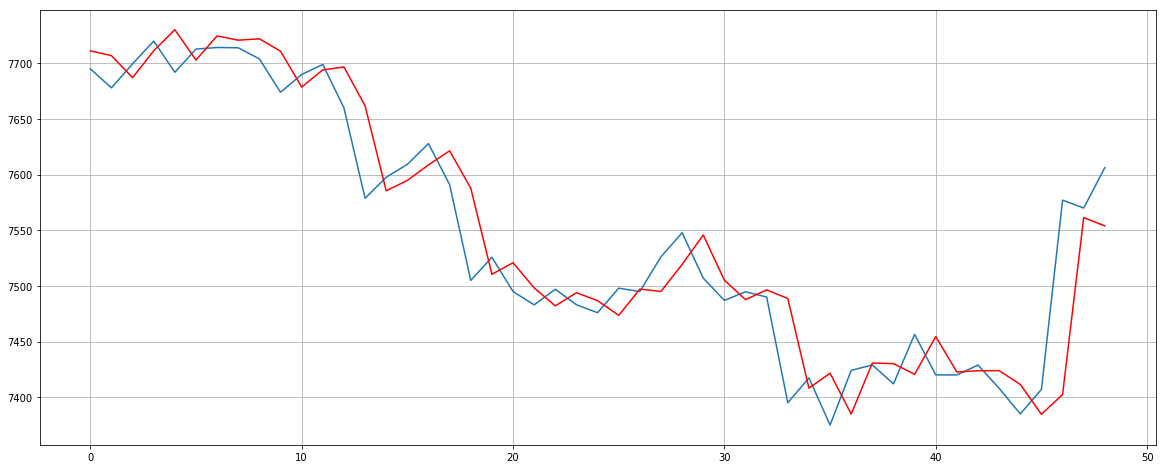

In [158]:
# plot
pyplot.figure(figsize=(20,8))
pyplot.plot(test[650:])
pyplot.plot(predictions[650:], color='red')
pyplot.grid(True)
pyplot.show()